In [2]:
!pip install foolbox

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout

In [5]:
!pip install adversarial-robustness-toolbox

  Using cached adversarial_robustness_toolbox-1.19.0-py3-none-any.whl.metadata (11 kB)
Using cached adversarial_robustness_toolbox-1.19.0-py3-none-any.whl (1.7 MB)


In [6]:
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.estimators.classification import KerasClassifier
from art.defences.trainer import AdversarialTrainerMadryPGD

In [7]:
(x_raw, y_raw), (x_raw_test, y_raw_test) = mnist.load_data()

In [8]:
# Нормализация данных
x_raw = x_raw.astype('float32') / 255.0
x_raw_test = x_raw_test.astype('float32') / 255.0

In [9]:
# Вычисляем минимальные и максимальные значения
min_ = np.min(x_raw)
max_ = np.max(x_raw)

In [10]:
# Преобразуем метки в формат one-hot
y_raw = np.eye(10)[y_raw]
y_raw_test = np.eye(10)[y_raw_test]

In [11]:
# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

In [12]:
def preprocess(x, y):
    # Нормализация данных
    x = x.astype('float32') / 255.0
    x = np.expand_dims(x, axis=-1)  # Добавление размерности канала для CNN
    return x, y

x_train, y_train = preprocess(x_raw, y_raw)
x_test, y_test = preprocess(x_raw_test, y_raw_test)

# Перемешивание обучающих данных
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

In [13]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(10, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [14]:
from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


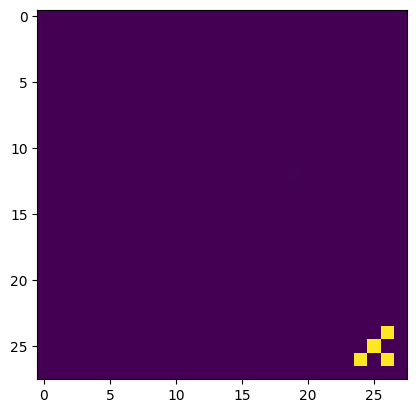

In [15]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)
plt.imshow(pdata[0].squeeze())


In [16]:
# f. Определение целевого класса
targets = to_categorical([9], 10)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9710 - loss: 0.0898
Test accuracy on clean images: 0.9765999913215637


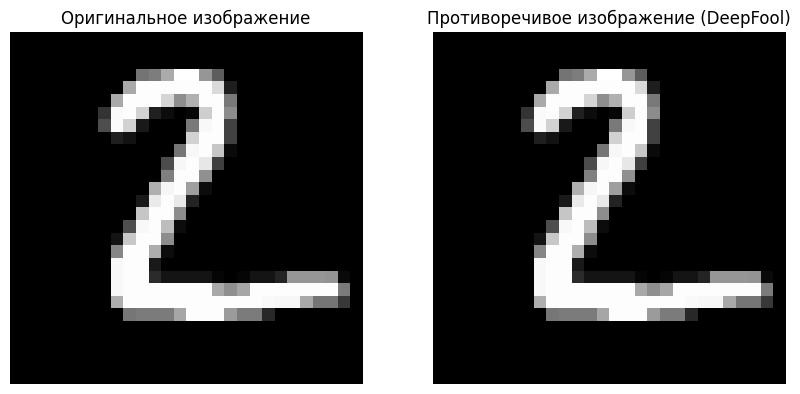

In [19]:

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')


import foolbox as fb
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения
image = tf.convert_to_tensor(test_images[1], dtype=tf.float32)[None, ...]
label = np.argmax(test_labels[0])
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Выполнение атаки
attack = fb.attacks.L2DeepFoolAttack(steps=10)
advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (DeepFool)")
plt.imshow(advs[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

Выполнение атаки для создания противоречивого примера
Объединяем все противоречивые изображения вдоль оси батча
Преобразуем метки в формат one-hot для корректного ранга
Оцениваем точность модели на противоречивых изображениях

In [20]:
# Список для хранения противоречивых изображений
adversarial_images = []
# Перебор каждого тестового изображения и создание противоречивого примера
for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    print(f"current image: {i+1}/10000", end='\r')
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 131.7773
Accuracy on adversarial examples (DeepFool): 0.0
